In [25]:
import scipy
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd

#Analysis
from scipy import signal
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from fooof import FOOOF
import pycatch22

# General Pipeline Guidelines
- Analysis: https://neurodsp-tools.github.io/neurodsp/
- Compute PSD https://neurodsp-tools.github.io/neurodsp/auto_tutorials/spectral/plot_SpectralPower.html#sphx-glr-auto-tutorials-spectral-plot-spectralpower-py
- time-frequency spectrograms: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/timefreq/plot_MorletWavelet.html#sphx-glr-auto-tutorials-timefreq-plot-morletwavelet-py
- Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise

Notes and to-do:
- Finalize a pipleline that will identify the correct session file for pre vs post op besides visual examination
- double check if FOOOF is taking log or no-log power spectrum

Catch 22 non-linear features package install and try on single electrode

recording duration, and recording sess gap table. 
use time_begin and End to have a information
extract 30 seconds stable LFP data from the full recording. 

write a function, signal as input, sliding window for duration. compute variance of signal over duration. 15 sec sliding window. return all the variance and timepoint (timepoint, variance). numpy variance.
variance on the matrix of chunk.
slicing.

# Data Loading

In [2]:
# Loading data from data folder
local_directory = '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926'
mat_files = glob.glob(f'{local_directory}/*.mat')
mat_files

['/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0001.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0002.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0003.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0004.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0005.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0006.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0007.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0008.mat']

In [3]:
def load_mat(dir_files):
    data_all = []
    for m in dir_files:
        file = scipy.io.loadmat(m)
        data_all.append(file)
    return data_all

data_all = load_mat(mat_files)

# Manual Examination of Recording session
Session 1,2,5,6 are excluded due to short recording

Putative OR operation happened between 5 & 6
- PreOp: 3 (8.7 m), 4 (5.4 m)
- PostOp: 7 (4.74 m), 8 (9.54 m)

work on down sample specification check

always look at the original sampling rate first before going to downsample.

In [33]:
# Import spectral power functions
from neurodsp.spectral import compute_spectrum, rotate_powerlaw

def load_channel(data, channel_name, downsample_factor=False):
    '''
    This function load a specific channel from one raw data file. Downsampling of the data should be applied once sampling rate has been examined.
    Input--------------------------
    data: 1xn, data signal
    channel_name: string, recording channel name
    downsample_factor: int
    Output-------------------------
    channel: raw or downsampled data
    sample_hz: sampling rate in Hz
    duration: total recording duration
    t_begin: relative recording start time
    t_end: relative recording end time
    '''

    channel = data[channel_name].flatten()
    sampling_rate = channel_name + '_KHz'
    channel_hz = data[sampling_rate].flatten()*1000
    print(channel_name, "sampling rate in hz", channel_hz)

    #downsample data
    channel = signal.decimate(channel, downsample_factor)
    sample_hz = channel_hz/downsample_factor
    if np.mod(channel_hz, downsample_factor) != 0:
        raise ValueError('Check your downsample factor')
  
    #get recording duration
    duration = channel.shape[0]/(60.0*channel_hz) #float operation
    print(channel_name, "duration", duration)

    #get recording start and end time
    t_begin = channel_name + '_TimeBegin'
    t_begin = data[t_begin]
    t_end = channel_name + '_TimeEnd'
    t_end = data[t_end]
    
    return channel, sample_hz, duration, t_begin, t_end 

In [21]:
#need to set the downsample_factor based on actual sampling rate first
pre_raw, pre_hz, pre_t, pre_begin, pre_end = load_channel(data_all[3], 'CRAW_01', downsample_factor = 44)
post_raw, post_hz, post_t, post_begin, post_end = load_channel(data_all[6], 'CRAW_01', downsample_factor = 44)

CRAW_01 sampling rate in hz [44000]
CRAW_01 duration [0.12266098]
CRAW_01 sampling rate in hz [44000]
CRAW_01 duration [0.10783561]


# Catch22 and FOOOF

In [31]:
def ff22(data, hz, sess):
    '''
    This function takes in a single signal and outputs a 1x29 dataframe containing the results from catch22 and FOOOF analysis.
    Input--------------------------
    data: 1xn, data signal
    hz: sampling rate
    sess: data file identification
    Output-------------------------
    df: 1x29 pandas dataframe
    '''
    # Catch22 
    c22 = pycatch22.catch22_all(data)

    # FOOOF
    freq_mean, psd_mean = compute_spectrum(data, hz, method='welch', avg_type='mean', nperseg=hz*2)
    new_freq = freq_mean[freq_mean<120]
    new_psd = psd_mean[freq_mean<120] #???? why select from freq_mean again? 

    fm = FOOOF() # Initialize FOOOF object
    freq_range = [2, 32] # Define frequency range across which to model the spectrum

    fm.fit(new_freq, new_psd, freq_range)
    # fm.report(new_freq, new_psd, freq_range)

    # Data organization
    c22_df = pd.DataFrame.from_dict(c22, orient='index')
    c22_df.columns = c22_df.iloc[0]
    c22_df.reset_index(inplace=True)
    c22_df.drop(0, inplace=True)
    c22_df.reset_index(inplace=True)
    c22_df.drop(['level_0', 'index'], axis=1, inplace=True)

    ff_param = fm.peak_params_
    aperiodic = fm.aperiodic_params_.reshape((1, 2))
    params_dic = {'offset': aperiodic[0,0], 'exponent':aperiodic[0,1],'n_peak': ff_param.shape[0], 'CF': [ff_param[:,0]], 'PW': [ff_param[:,1]], 'BW': [ff_param[:,2]]}
    ff_df = pd.DataFrame.from_dict(params_dic)

    df = pd.concat([c22_df, ff_df], axis=1)
    df.insert(loc=0, column='sess', value=sess)

    return df

In [30]:
ff22(post_raw, post_hz, 'post_op')


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



,sess,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,...,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr,offset,exponent,n_peak,CF,PW,BW
0,post_op,-0.205564,-0.660453,13477.392015,32,0.58277,-0.000008,0.090999,35917.0,0.0625,...,0.12,0.18,0.000096,0.044267,2.463873,1.82549,3,"[12.075895930319538, 18.600462072867334, 30.01...","[0.3965350844834068, 1.2647703253506206, 1.418...","[4.3043273723942646, 5.468132358381762, 0.8430..."


# Power spectral
This code block generate power spectral for each individual recording session for quick visualization of the session quality.


NOTES:
- There seems to be a harware filter at 60 hz, no peak signal at 60 hz from the power spectral graph.
- Need to ask all the hardware filter that has been applied to the raw data. 

In [ ]:
# Import spectral power functions
from neurodsp.spectral import compute_spectrum, rotate_powerlaw

In [ ]:
#plot for each file 
freq_list = []
psd_list = []

for m in mat_files:
    file = scipy.io.loadmat(m)
    CLFP_01 = file['CRAW_01'].flatten()
    CLFP_hz = file['CRAW_01_KHz'].flatten()*1000
    freq_mean, psd_mean = compute_spectrum(CLFP_01, CLFP_hz, method='welch', avg_type='mean', nperseg=CLFP_hz*2)

    #subset the frequence range below 120 hz
    new_freq = freq_mean[freq_mean<120]
    new_psd = psd_mean[freq_mean<120]
    freq_list.append(new_freq)
    psd_list.append(new_psd)


In [ ]:
f, ax = plt.subplots(2,4, figsize=(9,5))

ax[0,0].plot(freq_list[0], psd_list[0])
ax[0,1].plot(freq_list[1], psd_list[1])
ax[0,2].plot(freq_list[2], psd_list[2])
ax[0,3].plot(freq_list[3], psd_list[3])

ax[1,0].plot(freq_list[4], psd_list[4])
ax[1,1].plot(freq_list[5], psd_list[5])
ax[1,2].plot(freq_list[6], psd_list[6])
ax[1,3].plot(freq_list[7], psd_list[7])

# FOOOF  
- https://fooof-tools.github.io/fooof/
- https://github.com/valentinealissa/FOOOFy 


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

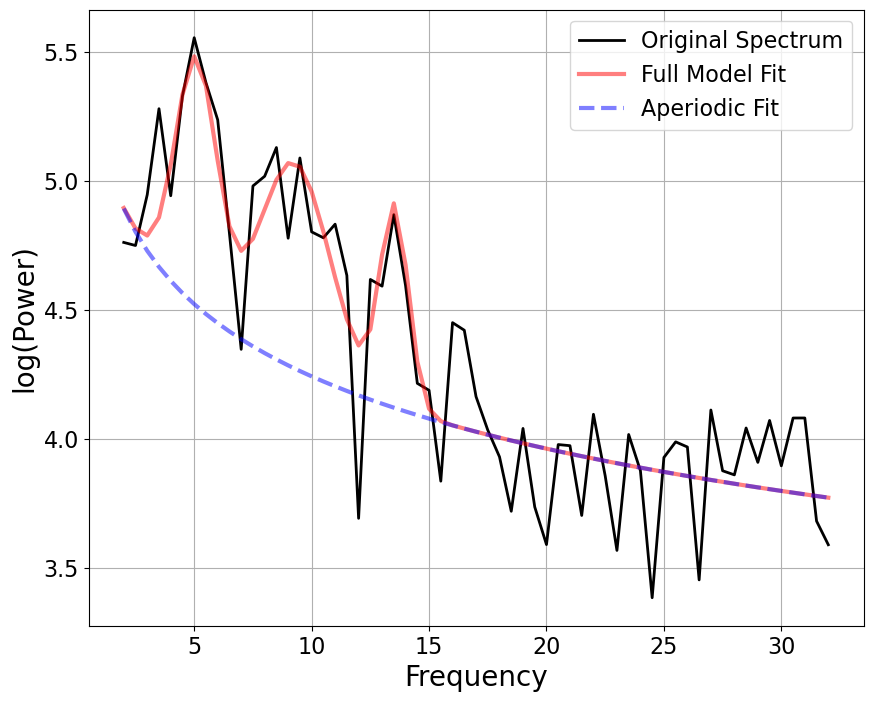

In [28]:
# get power spectral for pre-op
freq_mean, psd_mean = compute_spectrum(pre_raw, pre_hz, method='welch', avg_type='mean', nperseg=pre_hz*2)
new_freq = freq_mean[freq_mean<120]
new_psd = psd_mean[freq_mean<120] #???? why select from freq_mean again? 

# Initialize FOOOF object
fm = FOOOF()
# Define frequency range across which to model the spectrum
freq_range = [2, 32]

# Model the power spectrum with FOOOF, and print out a report
# fm.fit(new_freq, new_psd, freq_range)
fm.report(new_freq, new_psd, freq_range)

## plotting check

In [ ]:
# All data quick visualization
CLFP_all
plt.plot(pre_raw)

In [ ]:
# single data file examination
mat_file = scipy.io.loadmat(mat_files[4])
CLFP_01 = mat_file['CLFP_01']
plt.plot(CLFP_01[0,:])

# Pre-processing IIR filtering

Note:
- bandstop, exclusion.
- bandpass, inclusion. 

In [ ]:
# Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise
from neurodsp.filt import filter_signal

In [ ]:
#filtering test for CLFP
f_range = (58, 62)
sig_filt = filter_signal(CLFP_all, CLFP_hz, 'bandstop', f_range,
                         filter_type='iir', butterworth_order=3)

# Plot filtered signal for the first 1 second
plt.plot(sig_filt[0:1375]) #filtered
plt.plot(CLFP_all[0:1375]) #raw

In [ ]:
#filtering test for Raw data
f_range = (58, 62)
sig_filt = filter_signal(pre_raw, 1000, 'bandstop', f_range,
                         filter_type='iir', butterworth_order=3)

# Plot filtered signal for the first 1 second
# plt.plot(sig_filt[0:10000]) #filtered
plt.plot(pre_raw[0:10000]) #raw
plt.plot(sig_filt[0:10000]) #filtered

In [ ]:
# # tutorial testing

# from neurodsp.filt.iir import design_iir_filter, apply_iir_filter
# from neurodsp.filt.utils import compute_frequency_response, compute_transition_band
# Import plotting functions
# from neurodsp.plts import plot_frequency_response, plot_time_series

# n_seconds = 1
# fs = 1000

# # Define filter settings
# pass_type = 'bandstop'
# f_range = (58, 62) #freq range to filter out
# butterworth_order = 12

# # Design the filter, getting the second-order series (sos) values for the filter
# sos = design_iir_filter(fs, pass_type, f_range, butterworth_order)

# # Compute the frequency response for the IIR filter
# f_db, db = compute_frequency_response(sos, None, fs)

# # Plot the frequency response
# plot_frequency_response(f_db, db)

In [ ]:
# note for visualization 
# ax.set_xticklabels(np.round(new_freqs[np.linspace(0, len(new_freqs)-1, 6).astype(int)]))
# np.round(freq_mean[np.linspace(0, len(freq_mean)-1, 6).astype(int)])